In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm
import numpy as np

from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt

from ripser import Rips
from persim import PersistenceImager

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

import torch.nn as nn
import torch.nn.functional as F

from torch.nn import CrossEntropyLoss
import generators, modules
from utils import SlicedWasserstein
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau
from model import DataToPd

from modules import CustomPersformer
from utils import HungarianLoss
import time

# Geting datasets functions 

In [2]:
class ImagePds(Dataset):

    def __init__(self, X, y, X_orig, PI, transform=None):
        self.X = X
        self.y = y
        self.X_orig = X_orig
        self.PI = PI

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.X_orig[idx], self.PI[idx]

In [3]:
def collate_fn(data):

    tmp_pd, _, image, pimg = data[0]

    n_image = image.shape[0]

    n_batch = len(data)
    n_features_pd = tmp_pd.shape[1]
    n_points_pd = max(len(pd) for pd, _, _, _ in data)
    inputs_pd = np.zeros((n_batch, n_points_pd, n_features_pd), dtype=float)

    images = np.zeros((n_batch, n_image, n_image), dtype=float)

    mask = np.zeros((n_batch, n_points_pd))
    labels = np.zeros(len(data))
    PI = np.zeros((n_batch, pimg.shape[0], pimg.shape[1]))

    for i, (pd, label, image, pimg) in enumerate(data):
        inputs_pd[i][:len(pd)] = pd
        labels[i] = label
        mask[i][:len(pd)] = 1
        images[i] = image
        PI[i] = pimg
    return torch.Tensor(inputs_pd), torch.Tensor(mask).long(), torch.Tensor(labels).long(), \
            torch.Tensor(images), torch.Tensor(PI)

In [4]:
def generate(N, S, W=300, sigma1=4, sigma2=2, t=0.01, bins=64):

    z = np.zeros((N, S, 2))
    for n in range(N):
        z[n, 0] = np.random.uniform(0, W, size=(2))
        for s in range(S-1):
            d_1 = np.random.normal(0, sigma1)
            d_2 = np.random.normal(0, sigma1)
            z[n, s+1, 0] = (z[n, s, 0] + d_1) % W
            z[n, s+1, 1] = (z[n, s, 1] + d_2) % W

    z_r = z.reshape(N*S, 2)
    H, _, _ = np.histogram2d(z_r[:,0], z_r[:,1], bins=bins)
    
    G = gaussian_filter(H, sigma2)
    G[G < t] = 0
    
    return G

In [5]:
def conv_pd(diagrams):
    pd = np.zeros((0, 3))

    for k, diagram_k in enumerate(diagrams):
        if k != 0:
            diagram_k = diagram_k[~np.isinf(diagram_k).any(axis=1)] # filter infs
            diagram_k = np.concatenate((diagram_k, k * np.ones((diagram_k.shape[0], 1))), axis=1)
            if len(diagram_k) > 0:
                pd = np.concatenate((pd, diagram_k))

    return pd

In [6]:
def get_datasets_custom(n_images=5000, batch_size = 64, W = 300, sigma1 = 4, sigma2 = 2, 
                        t = 0.01, N1 = 100, S1 = 30, N2 = 250, S2 = 10, n_train = 0.8, 
                        bins=64, filtration = 'rips', pixel_size = 0.02,
                        birth_range = (0, 1), pers_range = (0, 1), sigma = 0.01):
    
    images = np.zeros((n_images, bins, bins))
    for n in tqdm(range(n_images // 2)):
        images[n] = generate(N1, S1, W, sigma1, sigma2, t, bins)

    for n in tqdm(range(n_images // 2)):
        images[n + n_images // 2] = generate(N2, S2, W, sigma1, sigma2, t, bins)
        
    all_diagrams = []
    images = torch.tensor(images)
    labels = torch.ones(n_images)
    labels[: n_images // 2] = 0
    
    
    pimgr = PersistenceImager(pixel_size=pixel_size)
    pimgr.birth_range = birth_range
    pimgr.pers_range = pers_range
    pimgr.kernel_params['sigma'] = sigma
    total_time = 0
    if filtration == 'rips':
        vr = Rips()
        for image in tqdm(images):
            
            nx, ny = image.shape
            x, y = torch.linspace(0, 1, nx), torch.linspace(0, 1, ny)
            xv, yv = torch.meshgrid(x, y)
            xv, yv, image = xv.unsqueeze(2), yv.unsqueeze(2), image.unsqueeze(2)
            res = torch.cat((xv, yv, image), 2).reshape(-1, 3)
            t1 = time.time()
            res = vr.fit_transform(res)
            t2 = time.time()
            total_time += t2 - t1
            diagram = conv_pd(res)
            diagram[:, 1] -= diagram[:, 0]
            all_diagrams.append(diagram)
            
    elif filtration == 'sublevel':
        import gudhi as gd
        
        for image in tqdm(images):
            image /= torch.max(image)
            cc_density_crater = gd.CubicalComplex(
                dimensions = [32 , 32], 
                top_dimensional_cells = image.flatten()
            )
            t1 = time.time()
            cc_density_crater.compute_persistence()
            t2 = time.time()
            total_time += t2 - t1
            diagram = cc_density_crater.persistence()
            
            pd = np.zeros((0, 3))
            for k, pair in diagram:
                if k == 1 and not np.isinf(pair[1]):
                    cur = np.zeros((1, 3))
                    cur[0, 0], cur[0, 1], cur[0, 2] = pair[0], pair[1] - pair[0], k
                    pd = np.concatenate((pd, cur))
            all_diagrams.append(pd)     
    else:
        raise NotImplementedError
        
        
    n_max = 0
    for x in all_diagrams:
        n_max = max(n_max, len(x))
    time_pis = 0
    t1 = time.time()
    pimgs = pimgr.transform(all_diagrams, skew=False)
    t2 = time.time()
    time_pis = t2 - t1
    dataset = ImagePds(all_diagrams, labels, images, pimgs)
    n_train = int(n_images * n_train)
    n_test = n_images - n_train

    dataset_train, dataset_test = random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(54))
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_test =  DataLoader(dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    print('Total time avg on one sample pd: {} seconds'.format(total_time / n_images))
    print('Total time avg on one sample pi: {} seconds'.format(time_pis / n_images))
    return dataset_train, dataset_test, dataloader_train, dataloader_test, n_max
        

# Get or load custom dataset

In [7]:
# dataloader_train = torch.load("../Downloads/dataloader_train_image_rips.pt")
# dataloader_test = torch.load("../Downloads/dataloader_test_image_rips.pt")

# n_max = 0
# for batch in dataloader_train:
#     n_max = max(n_max, batch[0].shape[1])

# for batch in dataloader_test:
#     n_max = max(n_max, batch[0].shape[1])

In [8]:
dataset_train, dataset_test, dataloader_train, dataloader_test, n_max = get_datasets_custom(n_images=1000, sigma = 0.0005, 
                                                                                            birth_range = (0, 1),
                                                                                            pers_range = (0, 1),
                                                                                            pixel_size = 0.02,
                                                                                            filtration='sublevel',
                                                                                            bins=32)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Total time avg on one sample pd: 0.0014925692081451415 seconds
Total time avg on one sample pi: 0.00044877028465270996 seconds


In [9]:
X_train, X_test = [], []
y_train, y_test = [], []

for batch in tqdm(dataloader_train):
    src_pd, mask, labels, src_data, PI = batch[0], batch[1], batch[2], batch[3], batch[4]
    for img in PI:
        X_train.append(img.numpy())
    for label in labels:
        y_train.append(label.numpy())
        
for batch in tqdm(dataloader_test):
    src_pd, mask, labels, src_data, PI = batch[0], batch[1], batch[2], batch[3], batch[4]
    for img in PI:
        X_test.append(img.numpy())
    for label in labels:
        y_test.append(label.numpy())
        
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = X_train.reshape((len(X_train), -1))
X_test = X_test.reshape((len(X_test), -1))

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

# Visualize

  0%|          | 0/13 [00:00<?, ?it/s]

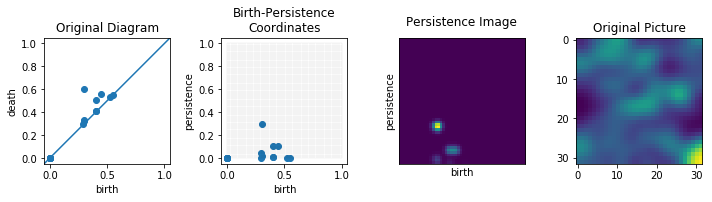

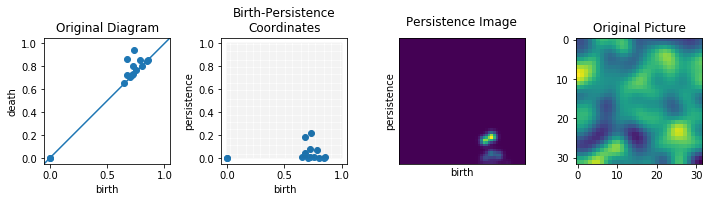

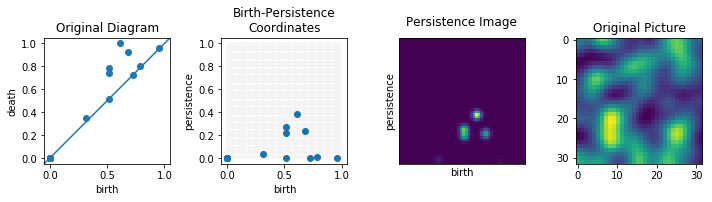

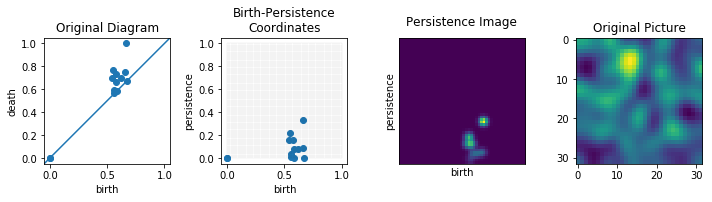

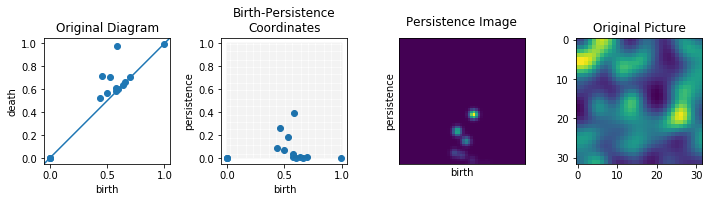

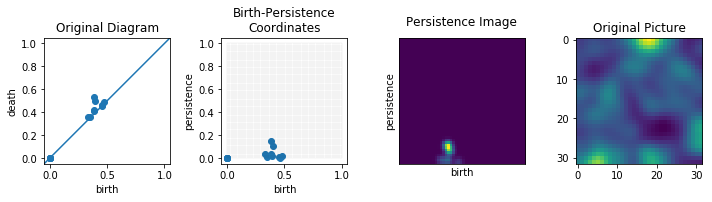

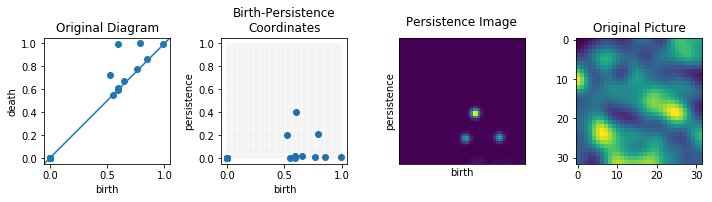

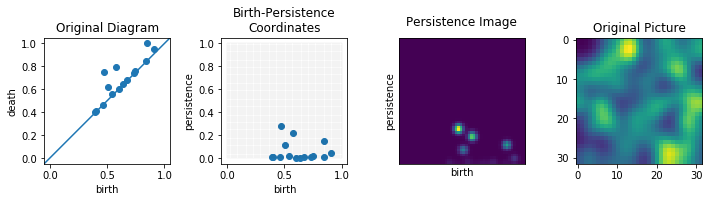

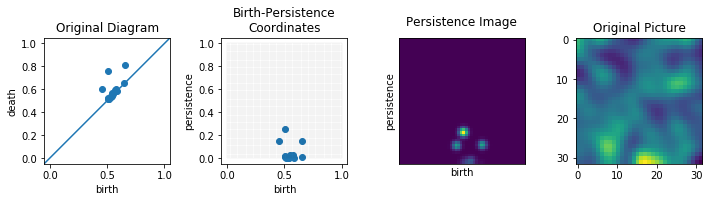

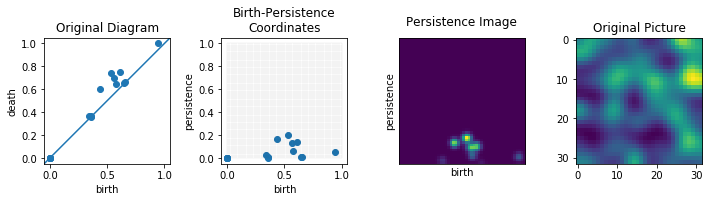

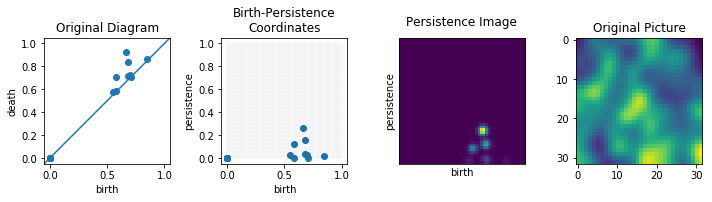

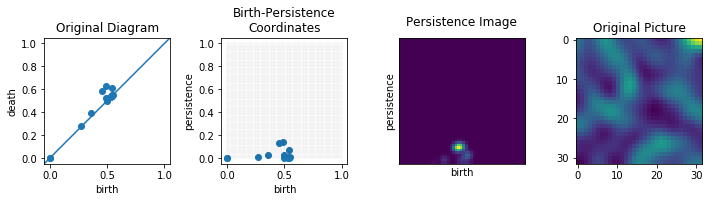

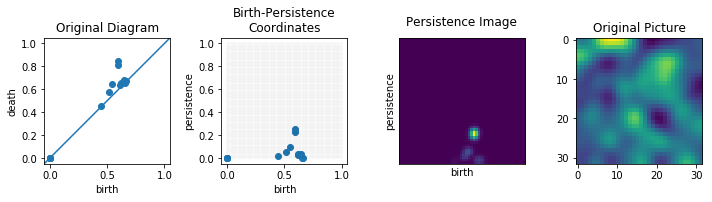

In [10]:
pimgr = PersistenceImager(pixel_size=0.02)
pimgr.birth_range = (0, 1)
pimgr.pers_range = (0, 1)
pimgr.kernel_params['sigma'] = 0.0005

for batch in tqdm(dataloader_train):
    src_pd, mask, labels, src_data, PI = batch[0], batch[1], batch[2], batch[3], batch[4]
    for i in range(1):
        pd = src_pd[i]
        pd[:, 1] += pd[:, 0]
        fig, axs = plt.subplots(1, 4, figsize=(10,5))

        axs[0].set_title("Original Diagram")
        pimgr.plot_diagram(pd.numpy(), skew=False, ax=axs[0])

        axs[1].set_title("Birth-Persistence\nCoordinates")
        pimgr.plot_diagram(pd.numpy(), skew=True, ax=axs[1])

        axs[2].set_title("Persistence Image")
        pimgr.plot_image(PI[i].numpy(), ax=axs[2])
        #axs[2].imshow(pimgs[0])

        axs[3].set_title("Original Picture")
        axs[3].imshow(src_data[i].numpy())

        plt.tight_layout()

# Calculate acc on original PIs (need add NN)

In [11]:
accuracies = []

for _ in range(5):
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train, y_train)
    accuracies.append(rfc.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.7660 ± 0.0058


In [12]:
accuracies = []

for _ in range(5):
    log_reg = LogisticRegression(C=100.0, max_iter = 1000)
    log_reg.fit(X_train, y_train)
    accuracies.append(log_reg.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.7700 ± 0.0000


# Compute acc on real images

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 3, 1)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 128)

    def forward(self, x, mask=None):
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
class NetClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 3, 1)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x, mask=None):
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#train classificator on images

crit = CrossEntropyLoss()
model_class = NetClass()
n_epochs = 30
lr = 1e-3
optimizer = AdamW(model_class.parameters(), lr=lr, weight_decay=1e-4)

for _ in range(n_epochs):
    model_class.train()
    loss, correct = 0.0, 0.0
    for batch in tqdm(dataloader_train):
        src_pd, mask, labels, src_data, PI = batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                                                batch[3].to(device), batch[4].to(device)
        logits = model_class(src_data.unsqueeze(1))
        loss_batch = crit(logits, labels)
        loss_batch.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss += loss_batch.detach().cpu()
        correct += (labels == torch.argmax(logits, axis=1)).sum()
    loss /= len(dataloader_train.dataset)
    correct /= len(dataloader_train.dataset)
    print("Train loss : {}\t Train acc : {}".format(loss, correct))
    
    model_class.eval()
    loss, correct = 0.0, 0.0
    for batch in tqdm(dataloader_test):
        with torch.no_grad():
            src_pd, mask, labels, src_data, PI = batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                                                batch[3].to(device), batch[4].to(device)
            logits = model_class(src_data.unsqueeze(1))
            loss_batch = crit(logits, labels)
            loss += loss_batch
            correct += (labels == torch.argmax(logits, axis=1)).sum()
    loss /= len(dataloader_test.dataset)
    correct /= len(dataloader_test.dataset)
    print("Test loss : {}\t Test acc : {}".format(loss, correct))

  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.011176261119544506	 Train acc : 0.5287500023841858


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.013706066645681858	 Test acc : 0.6949999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.010331336408853531	 Train acc : 0.6937500238418579


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.013024496845901012	 Test acc : 0.6700000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008892800658941269	 Train acc : 0.7149999737739563


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010426201857626438	 Test acc : 0.7699999809265137


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007322903256863356	 Train acc : 0.8012499809265137


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007494813296943903	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006557492073625326	 Train acc : 0.8187500238418579


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010996174067258835	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00645112618803978	 Train acc : 0.8125


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007222152315080166	 Test acc : 0.8700000047683716


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.005746279377490282	 Train acc : 0.8399999737739563


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010184216313064098	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.004888084717094898	 Train acc : 0.8887500166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.011331481859087944	 Test acc : 0.7649999856948853


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.004397058393806219	 Train acc : 0.8924999833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.006938299164175987	 Test acc : 0.8450000286102295


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00393030047416687	 Train acc : 0.9075000286102295


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0033607056830078363	 Test acc : 0.9449999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.004533371422439814	 Train acc : 0.8650000095367432


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0047925920225679874	 Test acc : 0.8450000286102295


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.003596237860620022	 Train acc : 0.9137499928474426


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.003366234712302685	 Test acc : 0.9399999976158142


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.003564189188182354	 Train acc : 0.9112499952316284


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0031390786170959473	 Test acc : 0.9449999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0033813980408012867	 Train acc : 0.918749988079071


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.003252217546105385	 Test acc : 0.9350000023841858


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.003057732479646802	 Train acc : 0.9262499809265137


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009732235223054886	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0031541669741272926	 Train acc : 0.9225000143051147


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0035248699132353067	 Test acc : 0.9300000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0023376948665827513	 Train acc : 0.9549999833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0029457213822752237	 Test acc : 0.9449999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.002855157945305109	 Train acc : 0.9275000095367432


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0034287867601960897	 Test acc : 0.9399999976158142


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.002480844035744667	 Train acc : 0.9424999952316284


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0028880087193101645	 Test acc : 0.9449999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.004199253395199776	 Train acc : 0.8924999833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.011630597524344921	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0033669276162981987	 Train acc : 0.90625


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.003620856674388051	 Test acc : 0.9200000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0022230050526559353	 Train acc : 0.9512500166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0028820030856877565	 Test acc : 0.9449999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.002872682409361005	 Train acc : 0.9350000023841858


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0028373857494443655	 Test acc : 0.9449999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.004056253470480442	 Train acc : 0.9037500023841858


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.003101343521848321	 Test acc : 0.9350000023841858


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0028755650855600834	 Train acc : 0.9275000095367432


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0035029854625463486	 Test acc : 0.9300000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.001971830613911152	 Train acc : 0.9474999904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.005139493383467197	 Test acc : 0.8849999904632568


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.002434549620375037	 Train acc : 0.9474999904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0061436849646270275	 Test acc : 0.8650000095367432


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.003684678114950657	 Train acc : 0.9024999737739563


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.003439237829297781	 Test acc : 0.9200000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.003634640946984291	 Train acc : 0.9049999713897705


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0036998011637479067	 Test acc : 0.9100000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0031951707787811756	 Train acc : 0.9162499904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0031618089415133	 Test acc : 0.9350000023841858


# Train our original model

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

encoder = Net()
generator = generators.TopNGenerator(set_channels=3, cosine_channels=32, max_n=n_max + 5, latent_dim=128)
#generator = generators.FirstKSetGenerator(set_channels=3, max_n=n_max + 10).to(device)
decoder = modules.TransformerDecoder(n_in=3, latent_dim=128, fc_dim=256, num_heads=4, num_layers=3, n_out=3,
                                            generator=generator, n_out_lin=128, n_hidden=256, num_layers_lin=1,
                                            dropout = 0.1, use_conv=True)
model = DataToPd(encoder, decoder)

lr = 0.001
warmup_iters = 10
n_epochs = 100 + warmup_iters
criterion = SlicedWasserstein(n_projections=50)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler1 = LinearLR(optimizer, start_factor=0.0001, total_iters=warmup_iters)

for epoch_idx in range(n_epochs):
    model.train()
    loss = 0
    for batch in tqdm(dataloader_train):
        src_pd, mask, labels, src_data, PI = batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                                            batch[3].to(device), batch[4].to(device)
        tgt_pd = model(src_data.unsqueeze(1), mask)
        loss_batch = criterion(src_pd.to(torch.float), tgt_pd)
        loss_batch.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss += loss_batch.detach().cpu()
    loss_train = loss / len(dataloader_train.dataset)

    loss = 0
    model.eval()
    for batch in tqdm(dataloader_test):
        with torch.no_grad():
            src_pd, mask, labels, src_data, PI = batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                                                batch[3].to(device), batch[4].to(device)
            tgt_pd = model(src_data.unsqueeze(1), mask)
            loss_batch = criterion(src_pd.to(torch.float), tgt_pd)
            loss += loss_batch
    loss_test = loss / len(dataloader_test.dataset)

    if epoch_idx < warmup_iters:
        scheduler1.step()
    else:
        if epoch_idx == warmup_iters:
            scheduler2 = ReduceLROnPlateau(optimizer, patience=25, min_lr=1e-5, factor=0.5)
        scheduler2.step(loss_test)
    
    print(loss_train, loss_test)
    #if epoch_idx % 30 == 0:
    #    data_to_pd_metrics(model, model_size, model_classificator, dataloader_test, name, n_max)

#data_to_pd_metrics(model, model_size, model_classificator, dataloader_test, name, n_max)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(1.1148) tensor(1.0719)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.6158) tensor(0.5553)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.4295) tensor(0.3069)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.2528) tensor(0.2205)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1828) tensor(0.1216)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1577) tensor(0.1442)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1399) tensor(0.1129)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1320) tensor(0.1206)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1250) tensor(0.1190)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1298) tensor(0.1096)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1425) tensor(0.1791)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1953) tensor(0.1324)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1182) tensor(0.1127)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1133) tensor(0.1120)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1063) tensor(0.1026)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1084) tensor(0.0761)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0915) tensor(0.0826)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0891) tensor(0.0865)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0814) tensor(0.0844)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0851) tensor(0.0696)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0810) tensor(0.0718)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0791) tensor(0.0700)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0785) tensor(0.1003)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0858) tensor(0.0984)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0826) tensor(0.0622)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0762) tensor(0.0647)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0771) tensor(0.0769)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.1104) tensor(0.0636)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0723) tensor(0.0696)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0707) tensor(0.0708)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0675) tensor(0.0657)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0688) tensor(0.0616)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0665) tensor(0.0695)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0671) tensor(0.0582)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0660) tensor(0.0597)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0633) tensor(0.0638)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0671) tensor(0.0578)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0628) tensor(0.0617)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0704) tensor(0.0718)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0669) tensor(0.0565)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0629) tensor(0.0607)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0678) tensor(0.0629)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0802) tensor(0.0934)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0972) tensor(0.0578)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0686) tensor(0.0696)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0615) tensor(0.0609)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0632) tensor(0.0692)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0636) tensor(0.0644)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0611) tensor(0.0605)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0620) tensor(0.0613)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0584) tensor(0.0552)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0580) tensor(0.0558)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0590) tensor(0.0628)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0593) tensor(0.0726)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0651) tensor(0.0737)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0674) tensor(0.0679)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0616) tensor(0.0614)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0575) tensor(0.0627)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0573) tensor(0.0589)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0567) tensor(0.0566)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0572) tensor(0.0680)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0608) tensor(0.0618)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0616) tensor(0.0556)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0582) tensor(0.0650)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0549) tensor(0.0577)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0545) tensor(0.0558)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0533) tensor(0.0577)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0537) tensor(0.0592)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0555) tensor(0.0616)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0563) tensor(0.0572)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0557) tensor(0.0632)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0573) tensor(0.0574)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0549) tensor(0.0584)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0532) tensor(0.0563)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0512) tensor(0.0648)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0531) tensor(0.0611)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0531) tensor(0.0662)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0527) tensor(0.0580)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0495) tensor(0.0576)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0487) tensor(0.0563)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0494) tensor(0.0561)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0481) tensor(0.0548)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0477) tensor(0.0557)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0470) tensor(0.0559)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0475) tensor(0.0547)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0470) tensor(0.0560)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0472) tensor(0.0546)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0467) tensor(0.0555)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0464) tensor(0.0551)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0465) tensor(0.0544)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0462) tensor(0.0554)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0465) tensor(0.0579)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0474) tensor(0.0580)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0467) tensor(0.0565)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0475) tensor(0.0605)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0472) tensor(0.0581)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0481) tensor(0.0575)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0463) tensor(0.0573)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0460) tensor(0.0551)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0449) tensor(0.0566)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0447) tensor(0.0563)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0448) tensor(0.0571)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0455) tensor(0.0545)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0441) tensor(0.0558)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0441) tensor(0.0570)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0443) tensor(0.0587)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0447) tensor(0.0556)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0440) tensor(0.0555)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0439) tensor(0.0558)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0433) tensor(0.0562)


  0%|          | 0/13 [00:00<?, ?it/s]

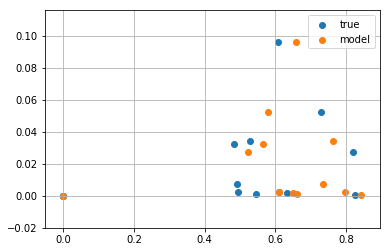

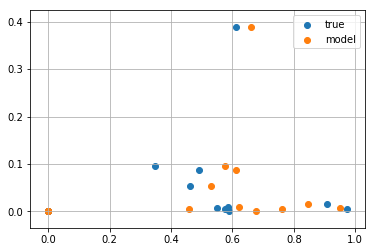

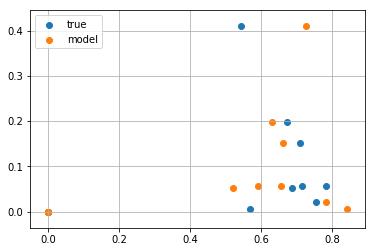

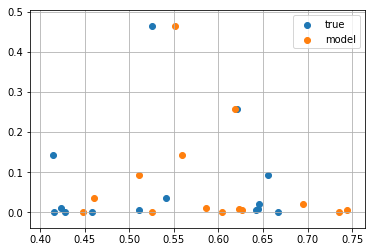

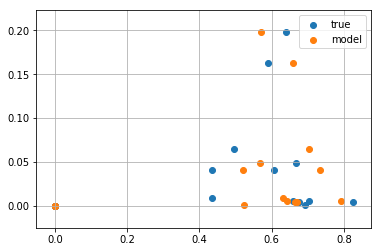

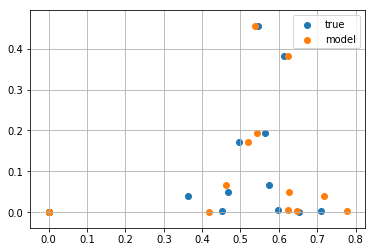

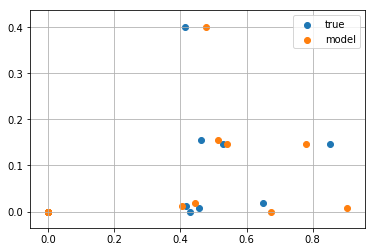

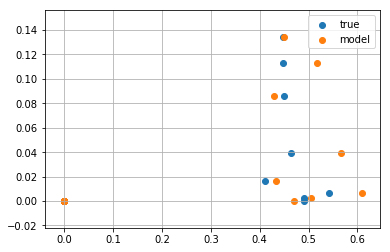

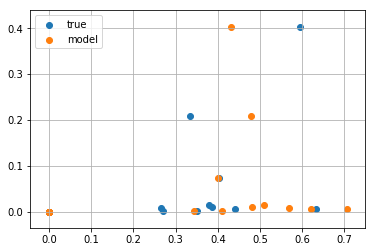

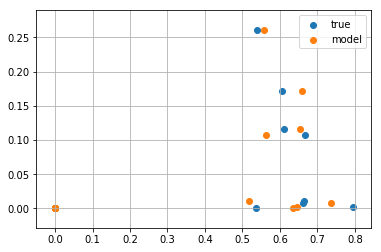

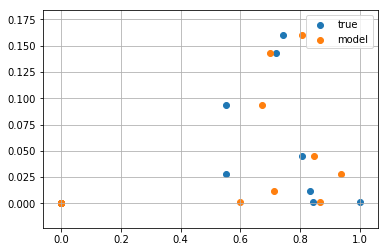

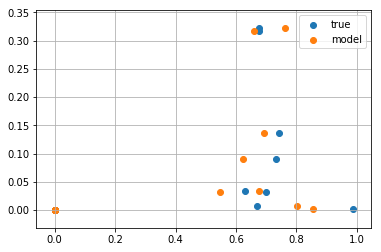

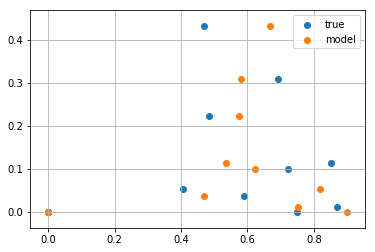

In [17]:
for batch in tqdm(dataloader_train):
    with torch.no_grad():
        src_pd, mask, labels, src_data = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)
        tgt_pd = model(src_data.unsqueeze(1), mask)
        plt.scatter(src_pd[0, :, 0], src_pd[0, :, 1], label='true')
        plt.scatter(tgt_pd[0, :, 0], src_pd[0, :, 1], label='model')
        plt.grid()
        plt.legend()
        plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

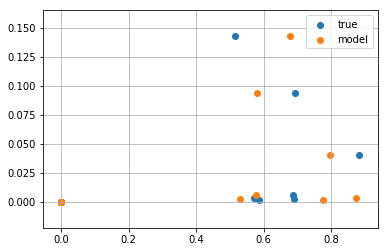

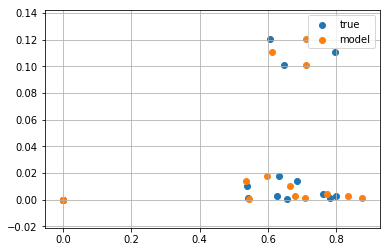

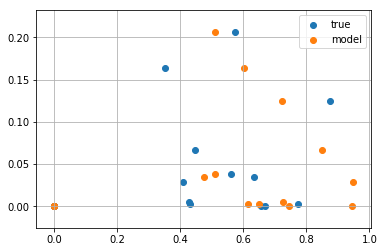

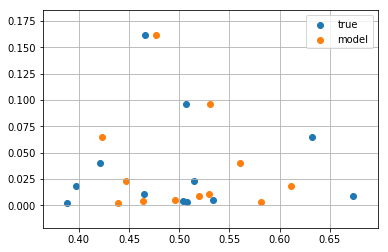

In [18]:
for batch in tqdm(dataloader_test):
    with torch.no_grad():
        src_pd, mask, labels, src_data = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)
        tgt_pd = model(src_data.unsqueeze(1), mask)
        plt.scatter(src_pd[0, :, 0], src_pd[0, :, 1], label='true')
        plt.scatter(tgt_pd[0, :, 0], src_pd[0, :, 1], label='model')
        plt.grid()
        plt.legend()
        plt.show()

# Compute PIE

  0%|          | 0/4 [00:00<?, ?it/s]

4.982682280772086e-06


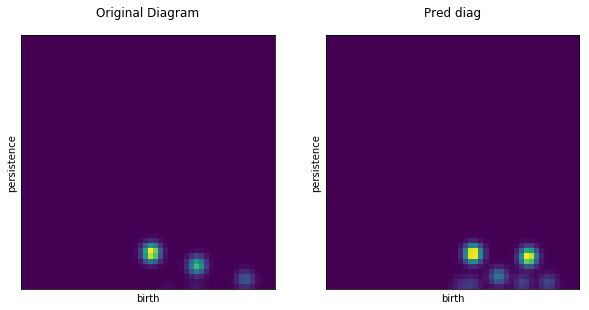

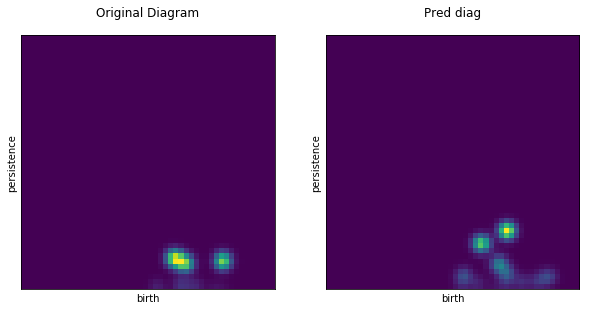

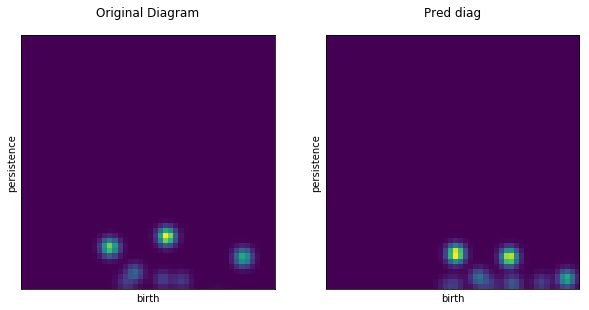

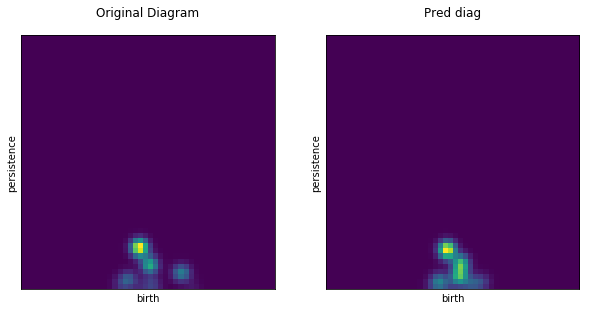

In [19]:
total_mse = 0

for batch in tqdm(dataloader_test):
    src_pd, mask, labels, src_data, PI = batch[0], batch[1], batch[2], batch[3], batch[4]
    pimgr = PersistenceImager(pixel_size=0.02)
    pimgr.birth_range = (0, 1)
    pimgr.pers_range = (0, 1)
    pimgr.kernel_params['sigma'] = 0.0005
    with torch.no_grad():
        pred_pds = model(src_data.unsqueeze(1), mask)
    pred_pds = pred_pds.numpy()
    
    approx_pi = np.array(pimgr.transform(pred_pds, skew = False))
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    
    axs[0].set_title("Original Diagram")
    pimgr.plot_image(PI.numpy()[0], ax=axs[0])

    axs[1].set_title("Pred diag")
    pimgr.plot_image(approx_pi[0], ax=axs[1])

    for i in range(len(PI)):
        total_mse += mean_squared_error(approx_pi[i].flatten(), PI[i].numpy().flatten())
        
print(total_mse / len(dataloader_test.dataset))

# Train classificator on pds (either real or pred) and compare acc

In [20]:
model_pd = CustomPersformer(n_in = 3, embed_dim = 64, fc_dim = 128, num_heads = 4, num_layers = 3, n_out_enc = 2)
crit = CrossEntropyLoss()
n_epochs = 100
lr = 1e-3
optimizer = AdamW(model_pd.parameters(), lr=lr, weight_decay=1e-4)

for _ in range(n_epochs):
    model_pd.train()
    loss, correct = 0.0, 0.0
    for batch in tqdm(dataloader_train):
        src_pd, mask, labels, src_data, PI = batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                                            batch[3].to(device), batch[4].to(device)
        
        with torch.no_grad():
            pred_pds = model(src_data.unsqueeze(1), mask)
            #pred_pds = src_pd.detach().clone()
        
        
        logits = model_pd(pred_pds, mask)
        loss_batch = crit(logits, labels)
        loss_batch.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss += loss_batch.detach().cpu()
        correct += (labels == torch.argmax(logits, axis=1)).sum()
    loss /= len(dataloader_train.dataset)
    correct /= len(dataloader_train.dataset)
    print("Train loss : {}\t Train acc : {}".format(loss, correct))
    
    model_pd.eval()
    loss, correct = 0.0, 0.0
    for batch in tqdm(dataloader_test):
        with torch.no_grad():
            src_pd, mask, labels, src_data, PI = batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                                                batch[3].to(device), batch[4].to(device)
            
            with torch.no_grad():
                pred_pds = model(src_data.unsqueeze(1), mask)
                #pred_pds = src_pd.detach().clone()
            
            logits = model_pd(pred_pds, mask)
            loss_batch = crit(logits, labels)
            loss += loss_batch
            correct += (labels == torch.argmax(logits, axis=1)).sum()
    loss /= len(dataloader_test.dataset)
    correct /= len(dataloader_test.dataset)
    print("Test loss : {}\t Test acc : {}".format(loss, correct))

  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.011254026554524899	 Train acc : 0.5074999928474426


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.013693291693925858	 Test acc : 0.6549999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.011068098247051239	 Train acc : 0.5575000047683716


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.013562704436480999	 Test acc : 0.6150000095367432


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.009885633364319801	 Train acc : 0.6612499952316284


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009602200239896774	 Test acc : 0.7200000286102295


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.010315533727407455	 Train acc : 0.6575000286102295


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.01360267959535122	 Test acc : 0.5799999833106995


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.009634536691009998	 Train acc : 0.675000011920929


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.015040373429656029	 Test acc : 0.6100000143051147


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.009203813038766384	 Train acc : 0.7362499833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.012747177854180336	 Test acc : 0.6700000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008909976109862328	 Train acc : 0.7262499928474426


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009688875637948513	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008866885676980019	 Train acc : 0.7425000071525574


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.012210058979690075	 Test acc : 0.6800000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008747199550271034	 Train acc : 0.7362499833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.01000188384205103	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00887750182300806	 Train acc : 0.7275000214576721


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010475657880306244	 Test acc : 0.7649999856948853


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008865972980856895	 Train acc : 0.737500011920929


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009879098273813725	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008992691524326801	 Train acc : 0.7337499856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008985664695501328	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008633816614747047	 Train acc : 0.7362499833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009922745637595654	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00839067529886961	 Train acc : 0.7549999952316284


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00974812638014555	 Test acc : 0.7649999856948853


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008614051155745983	 Train acc : 0.7662500143051147


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009221520274877548	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008457474410533905	 Train acc : 0.7362499833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008957465179264545	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008151368238031864	 Train acc : 0.7562500238418579


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.011314365081489086	 Test acc : 0.75


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008512470871210098	 Train acc : 0.7649999856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009956914000213146	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00805506482720375	 Train acc : 0.7837499976158142


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009872885420918465	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007998188026249409	 Train acc : 0.7787500023841858


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008182410150766373	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00810596626251936	 Train acc : 0.7699999809265137


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008526008576154709	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007795973215252161	 Train acc : 0.7762500047683716


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009910550899803638	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007574260234832764	 Train acc : 0.7950000166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008042508736252785	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007541730534285307	 Train acc : 0.8025000095367432


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009176121093332767	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007781250402331352	 Train acc : 0.7962499856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008100778795778751	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0075658587738871574	 Train acc : 0.793749988079071


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.011878001503646374	 Test acc : 0.7250000238418579


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007464343216270208	 Train acc : 0.8012499809265137


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007866998203098774	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007656297646462917	 Train acc : 0.7950000166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007957500405609608	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007368641905486584	 Train acc : 0.8162500262260437


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008997544646263123	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006971714552491903	 Train acc : 0.8112499713897705


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007633322384208441	 Test acc : 0.824999988079071


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007584660779684782	 Train acc : 0.7950000166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.011487593874335289	 Test acc : 0.6949999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0076954965479671955	 Train acc : 0.7912499904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.01046423427760601	 Test acc : 0.7599999904632568


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007059063762426376	 Train acc : 0.8199999928474426


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008122080937027931	 Test acc : 0.8149999976158142


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007235942408442497	 Train acc : 0.7950000166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0078100478276610374	 Test acc : 0.8149999976158142


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007512157782912254	 Train acc : 0.793749988079071


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007696177810430527	 Test acc : 0.824999988079071


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007084245793521404	 Train acc : 0.8199999928474426


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.011461450718343258	 Test acc : 0.7450000047683716


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0071314191445708275	 Train acc : 0.8075000047683716


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00906694121658802	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006946932058781385	 Train acc : 0.8050000071525574


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008814536035060883	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006806235760450363	 Train acc : 0.8212500214576721


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007586922496557236	 Test acc : 0.824999988079071


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007324982434511185	 Train acc : 0.8112499713897705


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008389536291360855	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007092343643307686	 Train acc : 0.8174999952316284


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00784492027014494	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00675307447090745	 Train acc : 0.8087499737739563


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007920504547655582	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007598519790917635	 Train acc : 0.7825000286102295


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00880119763314724	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007460435852408409	 Train acc : 0.8050000071525574


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009709537960588932	 Test acc : 0.7699999809265137


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007010283879935741	 Train acc : 0.8075000047683716


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010840863920748234	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0070457421243190765	 Train acc : 0.8137500286102295


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009996847249567509	 Test acc : 0.7549999952316284


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007478747516870499	 Train acc : 0.7862499952316284


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009455867111682892	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007477138191461563	 Train acc : 0.8087499737739563


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00925535336136818	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007040204480290413	 Train acc : 0.8187500238418579


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00816759467124939	 Test acc : 0.8149999976158142


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006850576493889093	 Train acc : 0.8337500095367432


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007934498600661755	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006507126614451408	 Train acc : 0.8299999833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009570854716002941	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006785798817873001	 Train acc : 0.8199999928474426


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010379357263445854	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006626944988965988	 Train acc : 0.8287500143051147


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009018532000482082	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006853991653770208	 Train acc : 0.8100000023841858


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008453909307718277	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0066671608947217464	 Train acc : 0.8287500143051147


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00808028969913721	 Test acc : 0.824999988079071


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006788972765207291	 Train acc : 0.8212500214576721


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008178322575986385	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006738533265888691	 Train acc : 0.8187500238418579


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.011184623464941978	 Test acc : 0.7200000286102295


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00677102105692029	 Train acc : 0.8237500190734863


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007741238921880722	 Test acc : 0.8450000286102295


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006633601617068052	 Train acc : 0.8299999833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007887250743806362	 Test acc : 0.8100000023841858


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006937642116099596	 Train acc : 0.8125


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00961704645305872	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007047715131193399	 Train acc : 0.8125


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008415557444095612	 Test acc : 0.8100000023841858


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006796864327043295	 Train acc : 0.824999988079071


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007732860278338194	 Test acc : 0.8199999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007003240752965212	 Train acc : 0.8137500286102295


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00749966548755765	 Test acc : 0.8349999785423279


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006532909348607063	 Train acc : 0.8324999809265137


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009851108305156231	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006566226948052645	 Train acc : 0.8262500166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00946593564003706	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0065576727502048016	 Train acc : 0.824999988079071


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008073821663856506	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006728733889758587	 Train acc : 0.8337500095367432


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00914289802312851	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007072002161294222	 Train acc : 0.8237500190734863


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008966583758592606	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007256519980728626	 Train acc : 0.8037499785423279


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00834447517991066	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007297488860785961	 Train acc : 0.800000011920929


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010948952287435532	 Test acc : 0.7549999952316284


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007045829202979803	 Train acc : 0.8075000047683716


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008235865272581577	 Test acc : 0.8199999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006597096100449562	 Train acc : 0.8262500166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00880336668342352	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0064835273660719395	 Train acc : 0.8424999713897705


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00777937239035964	 Test acc : 0.8399999737739563


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006651873700320721	 Train acc : 0.8299999833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008352438919246197	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006792587693780661	 Train acc : 0.8299999833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008910446427762508	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007082638796418905	 Train acc : 0.8149999976158142


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00929977186024189	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0073920427821576595	 Train acc : 0.7975000143051147


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007688276935368776	 Test acc : 0.824999988079071


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007896640338003635	 Train acc : 0.7900000214576721


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00836118496954441	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007164409384131432	 Train acc : 0.7962499856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007747775409370661	 Test acc : 0.8100000023841858


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006689984351396561	 Train acc : 0.824999988079071


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007448581047356129	 Test acc : 0.824999988079071


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006880557164549828	 Train acc : 0.8100000023841858


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008392992429435253	 Test acc : 0.824999988079071


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006673960480839014	 Train acc : 0.831250011920929


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008182714693248272	 Test acc : 0.8100000023841858


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006464781239628792	 Train acc : 0.8199999928474426


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008088329806923866	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00643040519207716	 Train acc : 0.8374999761581421


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007669826969504356	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007179089821875095	 Train acc : 0.7900000214576721


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007653636392205954	 Test acc : 0.8199999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006892967037856579	 Train acc : 0.8149999976158142


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007880810648202896	 Test acc : 0.8199999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0065675764344632626	 Train acc : 0.8224999904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008726616390049458	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006698417477309704	 Train acc : 0.8137500286102295


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010909638367593288	 Test acc : 0.7549999952316284


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006689176429063082	 Train acc : 0.8087499737739563


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009607898071408272	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006550362333655357	 Train acc : 0.8199999928474426


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.01020295824855566	 Test acc : 0.7699999809265137


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00652717100456357	 Train acc : 0.8274999856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008488280698657036	 Test acc : 0.8199999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006495405919849873	 Train acc : 0.8349999785423279


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009060440585017204	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006435502786189318	 Train acc : 0.8349999785423279


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008402138017117977	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0063849641010165215	 Train acc : 0.8387500047683716


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007833383046090603	 Test acc : 0.8299999833106995


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006468311417847872	 Train acc : 0.831250011920929


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007623780984431505	 Test acc : 0.8299999833106995


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0067947846837341785	 Train acc : 0.8137500286102295


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007933900691568851	 Test acc : 0.8199999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006498386152088642	 Train acc : 0.8374999761581421


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008812897838652134	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006268064957112074	 Train acc : 0.824999988079071


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.011507714167237282	 Test acc : 0.7599999904632568


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006403069477528334	 Train acc : 0.8374999761581421


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008988556452095509	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006246611475944519	 Train acc : 0.8387500047683716


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008792727254331112	 Test acc : 0.7850000262260437


In [21]:
model_pd = CustomPersformer(n_in = 3, embed_dim = 64, fc_dim = 128, num_heads = 4, num_layers = 3, n_out_enc = 2)
crit = CrossEntropyLoss()
n_epochs = 100
lr = 1e-3
optimizer = AdamW(model_pd.parameters(), lr=lr, weight_decay=1e-4)

for _ in range(n_epochs):
    model_pd.train()
    loss, correct = 0.0, 0.0
    for batch in tqdm(dataloader_train):
        src_pd, mask, labels, src_data, PI = batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                                            batch[3].to(device), batch[4].to(device)
        
        with torch.no_grad():
            #pred_pds = model(src_data.unsqueeze(1), mask)
            pred_pds = src_pd.detach().clone()
        
        
        logits = model_pd(pred_pds, mask)
        loss_batch = crit(logits, labels)
        loss_batch.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss += loss_batch.detach().cpu()
        correct += (labels == torch.argmax(logits, axis=1)).sum()
    loss /= len(dataloader_train.dataset)
    correct /= len(dataloader_train.dataset)
    print("Train loss : {}\t Train acc : {}".format(loss, correct))
    
    model_pd.eval()
    loss, correct = 0.0, 0.0
    for batch in tqdm(dataloader_test):
        with torch.no_grad():
            src_pd, mask, labels, src_data, PI = batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                                                batch[3].to(device), batch[4].to(device)
            
            with torch.no_grad():
                #pred_pds = model(src_data.unsqueeze(1), mask)
                pred_pds = src_pd.detach().clone()
            
            logits = model_pd(pred_pds, mask)
            loss_batch = crit(logits, labels)
            loss += loss_batch
            correct += (labels == torch.argmax(logits, axis=1)).sum()
    loss /= len(dataloader_test.dataset)
    correct /= len(dataloader_test.dataset)
    print("Test loss : {}\t Test acc : {}".format(loss, correct))

  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.011199801228940487	 Train acc : 0.5375000238418579


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.013826229609549046	 Test acc : 0.5149999856948853


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.01101071760058403	 Train acc : 0.5674999952316284


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.01153574325144291	 Test acc : 0.6949999928474426


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.009915562346577644	 Train acc : 0.6700000166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009564753621816635	 Test acc : 0.7699999809265137


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00892087072134018	 Train acc : 0.7387499809265137


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010868596844375134	 Test acc : 0.75


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008655973710119724	 Train acc : 0.7337499856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008643338456749916	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008172805421054363	 Train acc : 0.7674999833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008418875746428967	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00809809472411871	 Train acc : 0.768750011920929


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.01231229305267334	 Test acc : 0.7149999737739563


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008153703995049	 Train acc : 0.7524999976158142


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008317154832184315	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008023866452276707	 Train acc : 0.7637500166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009038244374096394	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008136856369674206	 Train acc : 0.7649999856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00929709430783987	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00778447650372982	 Train acc : 0.7662500143051147


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008478319272398949	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00737339910119772	 Train acc : 0.7912499904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007695856504142284	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008371838368475437	 Train acc : 0.7562500238418579


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009196224622428417	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007810692302882671	 Train acc : 0.7674999833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.011692962609231472	 Test acc : 0.7149999737739563


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007899712771177292	 Train acc : 0.7574999928474426


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009581510908901691	 Test acc : 0.7599999904632568


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008015911094844341	 Train acc : 0.7587500214576721


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008186692371964455	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0077006327919662	 Train acc : 0.7887499928474426


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007972907274961472	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007435953244566917	 Train acc : 0.7862499952316284


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010348578914999962	 Test acc : 0.75


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007139728870242834	 Train acc : 0.7825000286102295


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007823575288057327	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007373597472906113	 Train acc : 0.7912499904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008910895325243473	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007541499566286802	 Train acc : 0.7649999856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008302493952214718	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007401748094707727	 Train acc : 0.7825000286102295


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008152742870151997	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007307075895369053	 Train acc : 0.7862499952316284


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010040786117315292	 Test acc : 0.7699999809265137


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007111752405762672	 Train acc : 0.8037499785423279


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008266094140708447	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00727671105414629	 Train acc : 0.7900000214576721


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009229074232280254	 Test acc : 0.7649999856948853


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0072999680414795876	 Train acc : 0.7912499904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007741823326796293	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007315217982977629	 Train acc : 0.7850000262260437


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007467459887266159	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007390995044261217	 Train acc : 0.7749999761581421


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007872065529227257	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007740297820419073	 Train acc : 0.7762500047683716


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010993101634085178	 Test acc : 0.7099999785423279


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007591852452605963	 Train acc : 0.7737500071525574


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.014059292152523994	 Test acc : 0.7149999737739563


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007760816719383001	 Train acc : 0.7724999785423279


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.011759004555642605	 Test acc : 0.7200000286102295


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007613473571836948	 Train acc : 0.7762500047683716


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007669940125197172	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007330096792429686	 Train acc : 0.800000011920929


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00824398547410965	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007177792955189943	 Train acc : 0.793749988079071


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010103478096425533	 Test acc : 0.7599999904632568


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007257451303303242	 Train acc : 0.7837499976158142


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007548172492533922	 Test acc : 0.8050000071525574


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0072462125681340694	 Train acc : 0.7862499952316284


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008161685429513454	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007250598166137934	 Train acc : 0.793749988079071


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009343689307570457	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007377914618700743	 Train acc : 0.8037499785423279


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00928201712667942	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007312433328479528	 Train acc : 0.7912499904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007984627969563007	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007160283159464598	 Train acc : 0.7862499952316284


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007951213046908379	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0068804677575826645	 Train acc : 0.7987499833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007854343391954899	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007050244137644768	 Train acc : 0.7962499856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007947827689349651	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007362472824752331	 Train acc : 0.7774999737739563


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007516760844737291	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007340618874877691	 Train acc : 0.7925000190734863


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007837695069611073	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.008153840899467468	 Train acc : 0.7712500095367432


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007631680462509394	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007629683241248131	 Train acc : 0.7875000238418579


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00817684456706047	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007081851363182068	 Train acc : 0.793749988079071


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007747191935777664	 Test acc : 0.7649999856948853


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007204328663647175	 Train acc : 0.7987499833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00812059547752142	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007311727851629257	 Train acc : 0.7900000214576721


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0077049885876476765	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007159061264246702	 Train acc : 0.7962499856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007661175914108753	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007013087160885334	 Train acc : 0.7900000214576721


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008598235435783863	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007010329980403185	 Train acc : 0.7850000262260437


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008260257542133331	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006947612855583429	 Train acc : 0.8075000047683716


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008261122740805149	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007071671076118946	 Train acc : 0.8100000023841858


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008203276433050632	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006954377517104149	 Train acc : 0.8100000023841858


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007718739565461874	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007051313295960426	 Train acc : 0.7912499904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009953356347978115	 Test acc : 0.7599999904632568


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007215650286525488	 Train acc : 0.7837499976158142


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00849393755197525	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007642094045877457	 Train acc : 0.7862499952316284


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00932849571108818	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006898936815559864	 Train acc : 0.7950000166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00876510702073574	 Test acc : 0.7699999809265137


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007032554596662521	 Train acc : 0.8012499809265137


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010745390318334103	 Test acc : 0.7699999809265137


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0071689290925860405	 Train acc : 0.7925000190734863


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007557595148682594	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007116392720490694	 Train acc : 0.8037499785423279


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0074334233067929745	 Test acc : 0.7699999809265137


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007173502817749977	 Train acc : 0.7887499928474426


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007630091160535812	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007005853112787008	 Train acc : 0.8025000095367432


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008725170977413654	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006915317848324776	 Train acc : 0.8025000095367432


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00927945226430893	 Test acc : 0.7549999952316284


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00682437140494585	 Train acc : 0.7925000190734863


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008427992463111877	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006890620104968548	 Train acc : 0.8012499809265137


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008402672596275806	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006763888988643885	 Train acc : 0.7912499904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009009706787765026	 Test acc : 0.7599999904632568


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007192759308964014	 Train acc : 0.7962499856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00815399270504713	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007003300357609987	 Train acc : 0.7962499856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00802676472812891	 Test acc : 0.800000011920929


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006837841123342514	 Train acc : 0.8037499785423279


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007942699827253819	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006727266125380993	 Train acc : 0.8037499785423279


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007547246292233467	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006800493225455284	 Train acc : 0.7912499904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010969680733978748	 Test acc : 0.7350000143051147


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006986162159591913	 Train acc : 0.7912499904632568


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008660738356411457	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007059482391923666	 Train acc : 0.800000011920929


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008619981817901134	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006743103731423616	 Train acc : 0.7987499833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007636323105543852	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006937173195183277	 Train acc : 0.8012499809265137


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008428129367530346	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006826010532677174	 Train acc : 0.8062499761581421


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008195750415325165	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006680652964860201	 Train acc : 0.7987499833106995


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0078322384506464	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0066069066524505615	 Train acc : 0.7950000166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008747933432459831	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0069418130442500114	 Train acc : 0.7875000238418579


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007699172478169203	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0068824402987957	 Train acc : 0.8050000071525574


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008555179461836815	 Test acc : 0.7749999761581421


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006949594244360924	 Train acc : 0.7950000166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008353432640433311	 Test acc : 0.7699999809265137


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006421220954507589	 Train acc : 0.8162500262260437


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00905828457325697	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006719193421304226	 Train acc : 0.8037499785423279


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008427541702985764	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006691758055239916	 Train acc : 0.8075000047683716


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009952143765985966	 Test acc : 0.7699999809265137


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006844028364866972	 Train acc : 0.8087499737739563


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009889861568808556	 Test acc : 0.7450000047683716


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006807358935475349	 Train acc : 0.8075000047683716


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.010717363096773624	 Test acc : 0.7450000047683716


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006984736304730177	 Train acc : 0.7850000262260437


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009708670899271965	 Test acc : 0.7549999952316284


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006410492118448019	 Train acc : 0.8187500238418579


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.01100014429539442	 Test acc : 0.7649999856948853


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006874492391943932	 Train acc : 0.8050000071525574


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007840214297175407	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.007033936213701963	 Train acc : 0.8262500166893005


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007765666116029024	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006954787764698267	 Train acc : 0.7837499976158142


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008834077045321465	 Test acc : 0.7950000166893005


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006824000272899866	 Train acc : 0.793749988079071


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.007674266584217548	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00710179191082716	 Train acc : 0.8025000095367432


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008192329667508602	 Test acc : 0.7850000262260437


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006801129784435034	 Train acc : 0.800000011920929


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.008546002209186554	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006823642645031214	 Train acc : 0.8125


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009135720320045948	 Test acc : 0.7900000214576721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.00705872755497694	 Train acc : 0.8112499713897705


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00854821689426899	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006673227529972792	 Train acc : 0.8050000071525574


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.00895741768181324	 Test acc : 0.7799999713897705


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.006931766867637634	 Train acc : 0.7962499856948853


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.009983256459236145	 Test acc : 0.7649999856948853


In [22]:
model_pd.eval()
model.eval()

# compare acc on pred pds and real
# (works if trained on real pds)

correct_orig, correct_pred = 0.0, 0.0
for batch in tqdm(dataloader_train):
    with torch.no_grad():
        src_pd, mask, labels, src_data = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)

        pred_pd = model(src_data.unsqueeze(1), mask)

        logits_orig = model_pd(src_pd, mask)
        logits_pred = model_pd(pred_pd, mask)

        correct_orig += (labels == torch.argmax(logits_orig, axis=1)).sum()
        correct_pred += (labels == torch.argmax(logits_pred, axis=1)).sum()

correct_orig /= len(dataloader_train.dataset)
correct_pred /= len(dataloader_train.dataset)
print("Orig train acc : {}\t Pred train acc : {}".format(correct_orig, correct_pred))

correct_orig, correct_pred = 0.0, 0.0
for batch in tqdm(dataloader_test):
    with torch.no_grad():
        src_pd, mask, labels, src_data = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)

        pred_pd = model(src_data.unsqueeze(1), mask)

        logits_orig = model_pd(src_pd, mask)
        logits_pred = model_pd(pred_pd, mask)

        correct_orig += (labels == torch.argmax(logits_orig, axis=1)).sum()
        correct_pred += (labels == torch.argmax(logits_pred, axis=1)).sum()

correct_orig /= len(dataloader_test.dataset)
correct_pred /= len(dataloader_test.dataset)
print("Orig test acc : {}\t Pred test acc : {}".format(correct_orig, correct_pred))

  0%|          | 0/13 [00:00<?, ?it/s]

Orig train acc : 0.8162500262260437	 Pred train acc : 0.65625


  0%|          | 0/4 [00:00<?, ?it/s]

Orig test acc : 0.7649999856948853	 Pred test acc : 0.7149999737739563


# Compute other metrics (time and W2)

In [23]:
hung = HungarianLoss()

for batch in tqdm(dataloader_train):
    loss = 0
    with torch.no_grad():
        src_pd, mask, labels, src_data, PI = batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                                            batch[3].to(device), batch[4].to(device)
        tgt_pd = model(src_data.unsqueeze(1), mask)
        loss_batch = hung(src_pd.to(torch.float), tgt_pd)
        loss += loss_batch
W2 = loss / len(dataloader_train.dataset)
print(W2)
total_time = 0
for batch in tqdm(dataloader_test):
    loss = 0
    with torch.no_grad():
        src_pd, mask, labels, src_data, PI = batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                                            batch[3].to(device), batch[4].to(device)
        t1 = time.time()
        tgt_pd = model(src_data.unsqueeze(1), mask)
        t2 = time.time()
        total_time += t2 - t1
        loss_batch = hung(src_pd.to(torch.float), tgt_pd)
        loss += loss_batch
W2 = loss / len(dataloader_test.dataset)
total_time /= len(dataloader_test.dataset)
print(W2)
print('Avg time on sample : {} seconds on CPU'.format(total_time))

  0%|          | 0/13 [00:00<?, ?it/s]

tensor(0.0020)


  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0020)
Avg time on sample : 0.00058097243309021 seconds on CPU


In [24]:
X_train, X_test = [], []
y_train, y_test = [], []

for batch in tqdm(dataloader_train):
    src_pd, mask, labels, src_data, PI = batch[0], batch[1], batch[2], batch[3], batch[4]
    pimgr = PersistenceImager(pixel_size=0.02)
    pimgr.birth_range = (0, 1)
    pimgr.pers_range = (0, 1)
    pimgr.kernel_params['sigma'] = 0.0005
    with torch.no_grad():
        pred_pds = model(src_data.unsqueeze(1), mask)
    pred_pds = pred_pds.numpy()
    
    approx_pi = np.array(pimgr.transform(pred_pds, skew = False)).reshape((-1, 50*50))
    for pi in approx_pi:
        X_train.append(pi)
    for label in labels:
        y_train.append(label)
        
for batch in tqdm(dataloader_test):
    src_pd, mask, labels, src_data, PI = batch[0], batch[1], batch[2], batch[3], batch[4]
    pimgr = PersistenceImager(pixel_size=0.02)
    pimgr.birth_range = (0, 1)
    pimgr.pers_range = (0, 1)
    pimgr.kernel_params['sigma'] = 0.0005
    with torch.no_grad():
        pred_pds = model(src_data.unsqueeze(1), mask)
    pred_pds = pred_pds.numpy()
    
    approx_pi = np.array(pimgr.transform(pred_pds, skew = False)).reshape((-1, 50*50))
    for pi in approx_pi:
        X_test.append(pi)
    for label in labels:
        y_test.append(label)
    
        
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = X_train.reshape((len(X_train), -1))
X_test = X_test.reshape((len(X_test), -1))

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
accuracies = []

for _ in range(5):
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train, y_train)
    accuracies.append(rfc.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.7910 ± 0.0020


In [26]:
accuracies = []

for _ in range(5):
    log_reg = LogisticRegression(C=100.0, max_iter = 1000)
    log_reg.fit(X_train, y_train)
    accuracies.append(log_reg.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.7850 ± 0.0000


# PI - Net experiments

In [27]:
class PI_Net(nn.Module):
    def __init__(self, in_channels = 3):
        super(PI_Net, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = 128, kernel_size = 3, stride = 1, padding = 'same'),
            nn.BatchNorm2d(num_features = 128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 'same'),
            nn.BatchNorm2d(num_features = 256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 'same'), 
            nn.BatchNorm2d(num_features = 512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2) 
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 'same'), 
            nn.BatchNorm2d(num_features = 1024),
            nn.ReLU(),
            nn.AvgPool2d(4)
        )
        self.dense = nn.Sequential(
            nn.Linear(1024, 2500),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 1, out_channels = in_channels, kernel_size = 51, padding = 25),
            nn.BatchNorm2d(num_features = in_channels),
            nn.ReLU(),
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.dense(x)
        x = x.reshape((-1, 1, 50, 50))
        x = self.decoder(x)
        return x.reshape((-1, 50 * 50 * x.shape[1]))

In [28]:
pinet_model = PI_Net(in_channels = 1)

crit = CrossEntropyLoss()
n_epochs = 300
lr = 1e-3
optimizer = AdamW(pinet_model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, patience=25, min_lr=1e-6, factor=0.5)

for _ in range(n_epochs):
    pinet_model.train()
    loss = 0.0
    for batch in tqdm(dataloader_train):
        src_pd, mask, labels, src_data, PI = batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                                            batch[3].to(device), batch[4].to(device)
        
        
        out = pinet_model(PI.unsqueeze(1))
        loss_batch = crit(out, PI.reshape((-1, 2500)))
        loss_batch.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss += loss_batch.detach().cpu()
    loss /= len(dataloader_train.dataset)
    print("Train loss : {}".format(loss))
    
    pinet_model.eval()
    loss = 0.0
    for batch in tqdm(dataloader_test):
        with torch.no_grad():
            src_pd, mask, labels, src_data, PI = batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                                                    batch[3].to(device), batch[4].to(device)

            out = pinet_model(PI.unsqueeze(1))
            loss_batch = crit(out, PI.reshape((-1, 2500)))
            loss += loss_batch
    loss /= len(dataloader_test.dataset)
    print("Test loss : {}".format(loss))
    scheduler.step(loss)

  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.08044414222240448


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09120283275842667


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.07535383850336075


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09147880226373672


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.07386760413646698


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09122548252344131


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.07200422137975693


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09293641895055771


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.07047592103481293


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09397247433662415


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06977953016757965


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09398940950632095


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06882691383361816


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09049040824174881


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06749801337718964


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.08317501842975616


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06646206229925156


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.08242587000131607


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06588426232337952


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.07905998826026917


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06545017659664154


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.08109426498413086


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06467457115650177


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.07742497324943542


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06398605555295944


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.08019629120826721


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06416784971952438


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.08907932043075562


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06276920437812805


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.08535636216402054


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.062368374317884445


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.08719883114099503


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06200458109378815


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0853511169552803


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06141207367181778


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0907798483967781


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06176172196865082


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09761922806501389


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0606943741440773


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.08754545450210571


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06064946576952934


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.11376363784074783


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.06057804077863693


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09814837574958801


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.059675347059965134


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09483931213617325


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.059530772268772125


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.10942617058753967


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05916392803192139


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09111030399799347


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05892038717865944


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.1157994195818901


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05826827883720398


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.10499217361211777


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.058024536818265915


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09043128788471222


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05803433433175087


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.13778848946094513


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05770198255777359


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.18199516832828522


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.058039840310811996


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.13061483204364777


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05775313451886177


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.11267103254795074


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05721412971615791


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.10585586726665497


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05681091174483299


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0844498723745346


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05665082111954689


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.08174287527799606


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0566478930413723


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.14719560742378235


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05687575042247772


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.1424872875213623


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05658606067299843


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.1524604856967926


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05649551749229431


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.06955540180206299


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05582839623093605


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.0872296541929245


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05547071993350983


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.07586009055376053


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.055465374141931534


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.06738375872373581


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.055379319936037064


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.06625000387430191


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05511952564120293


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.06672505289316177


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.055111318826675415


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.06835434585809708


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.054911065846681595


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.11488790810108185


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05493076890707016


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.13952232897281647


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0547497496008873


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.13482286036014557


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.054733943194150925


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.11948986351490021


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05499016121029854


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.06850717216730118


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.054854974150657654


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.06675278395414352


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.054945796728134155


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.06808821856975555


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05470307916402817


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.06591024994850159


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.0550009049475193


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.07166320085525513


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.054616257548332214


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.07271286845207214


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.054442547261714935


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09284472465515137


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05451059713959694


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.08373858779668808


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.05442152917385101


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.09272616356611252


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.054439593106508255


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.12569132447242737


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss : 0.054233573377132416


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss : 0.06676046550273895


  0%|          | 0/13 [00:00<?, ?it/s]

KeyboardInterrupt: 

# PI-Net Log Reg + Random Forest

In [29]:
X_train, X_test = [], []
y_train, y_test = [], []

for batch in tqdm(dataloader_train):
    src_pd, mask, labels, src_data, PI = batch[0], batch[1], batch[2], batch[3], batch[4]
    with torch.no_grad():
        out = pinet_model(PI.unsqueeze(1))
        out = out.squeeze(1)
    for img in out:
        X_train.append(img.numpy())
    for label in labels:
        y_train.append(label.numpy())
        
for batch in tqdm(dataloader_test):
    src_pd, mask, labels, src_data, PI = batch[0], batch[1], batch[2], batch[3], batch[4]
    with torch.no_grad():
        out = pinet_model(PI.unsqueeze(1))
        out = out.squeeze(1)
    for img in out:
        X_test.append(img.numpy())
    for label in labels:
        y_test.append(label.numpy())
        
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = X_train.reshape((len(X_train), -1))
X_test = X_test.reshape((len(X_test), -1))

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [30]:
accuracies = []

for _ in range(5):
    rfc = RandomForestClassifier(n_estimators=75)
    rfc.fit(X_train, y_train)
    accuracies.append(rfc.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.7470 ± 0.0024


In [31]:
accuracies = []

for _ in range(5):
    log_reg = LogisticRegression(C=1.0, max_iter = 1000)
    log_reg.fit(X_train, y_train)
    accuracies.append(log_reg.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

C:\Users\yura-\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\yura-\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

Accuracy: 0.7100 ± 0.0000


C:\Users\yura-\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Visualize + metrics

  0%|          | 0/4 [00:00<?, ?it/s]

Time: 0.027254910469055177
PIE: 2.019522831737995


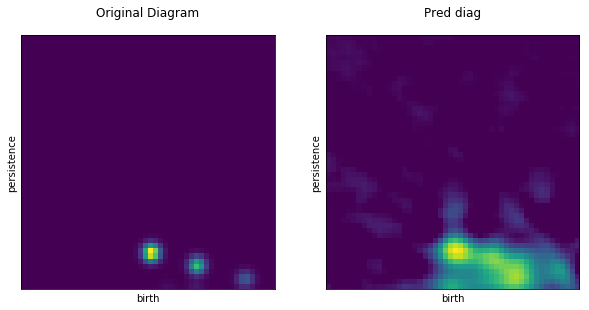

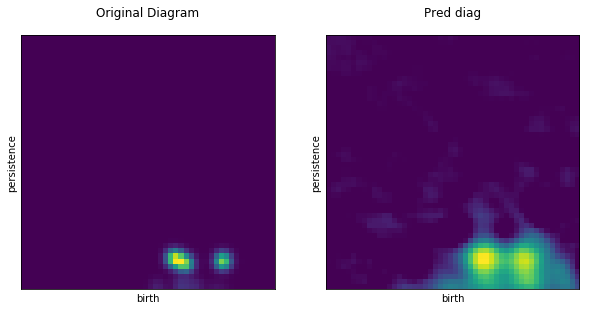

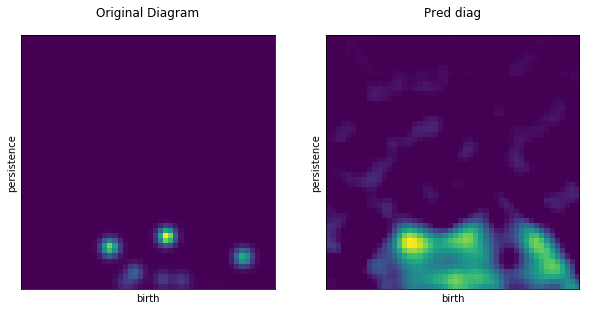

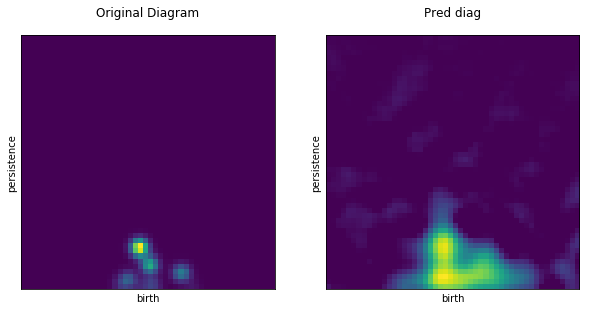

In [32]:
total_mse = 0
total_time = 0
for batch in tqdm(dataloader_test):
    src_pd, mask, labels, src_data, PI = batch[0], batch[1], batch[2], batch[3], batch[4]
    pimgr = PersistenceImager(pixel_size=0.02)
    pimgr.birth_range = (0, 1)
    pimgr.pers_range = (0, 1)
    pimgr.kernel_params['sigma'] = 0.0005
    with torch.no_grad():
        t1 = time.time()
        approx_pi = pinet_model(PI.unsqueeze(1)).squeeze(1).numpy().reshape((-1, 50, 50))
        t2 = time.time()
        total_time += t2 - t1
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    
    axs[0].set_title("Original Diagram")
    pimgr.plot_image(PI.numpy()[0], ax=axs[0])

    axs[1].set_title("Pred diag")
    pimgr.plot_image(approx_pi[0], ax=axs[1])

    for i in range(len(PI)):
        total_mse += mean_squared_error(approx_pi[i].flatten(), PI[i].numpy().flatten())
print('Time:', total_time / len(dataloader_test.dataset))
print('PIE:', total_mse / len(dataloader_test.dataset))